<a href="https://colab.research.google.com/github/p73rl11zq/AI4Sea/blob/main/AI4Sea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import torch
import random
import numpy as np

import sklearn
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
# matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)

!pip install category_encoders
from category_encoders.binary import BinaryEncoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 686 kB/s 


In [2]:
seed = 42

random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

> # **Challenge info**



All data about challenge available via the link:
https://dsworks.ru/champ/545de8cb-e023-4b64-9be4-b95b9519f8d3#overview

> # **Data reading**



In [3]:
from google.colab import drive
drive.mount('/content/drive') # force_remount=True

Mounted at /content/drive


In [4]:
pollok_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI4Sea/data/polock_dataset_train.csv', parse_dates=['date', 'datetimes'], dayfirst=True) # 
pollok_df = pollok_df.drop(['Unnamed: 0'], axis=1) 

In [5]:
pollok_df.head(3)

,idves,date,datetimes,idinf,latitude,longitude,region,course,velocity,ton,total_ton,trawl,science
0,cc2b1ba0368ccd98d5bed7e2e97b4bb0,2003-01-29,2003-01-29 00:48:00,52,54.3307,154.1080,274,350.0,4.0,0.0,71.9002,трал р/гл не зарегистрированный НПО ПР,0
1,cc2b1ba0368ccd98d5bed7e2e97b4bb0,2003-01-29,2003-01-29 01:22:00,32,54.3687,154.0987,274,351.0,4.0,0.0,71.9002,трал р/гл не зарегистрированный НПО ПР,0
2,cc2b1ba0368ccd98d5bed7e2e97b4bb0,2003-01-29,2003-01-29 02:14:00,52,54.4260,154.0993,274,6.0,4.0,0.0,71.9002,трал р/гл не зарегистрированный НПО ПР,0


In [ ]:
pollok_df.isna().sum()

idves        0
date         0
datetimes    0
idinf        0
latitude     0
longitude    0
region       0
course       0
velocity     0
ton          0
total_ton    0
trawl        0
science      0
dtype: int64

In [ ]:
print("-- Velocity: ")
print('Minimum: ', pollok_df['velocity'].min(), '\n', 'Maximum: ', pollok_df['velocity'].max())
print('Median: ', pollok_df["velocity"].median(), '\n', 'Mean value: ', pollok_df["velocity"].mean())

print('\n', '-- Course: ')
print('Minimum: ', pollok_df['course'].min(), '\n','Maximum: ', pollok_df['course'].max())
print('Median: ', pollok_df["course"].median(), '\n', 'Mean value: ', pollok_df["course"].mean())

-- Velocity: 
Minimum:  0.0 
 Maximum:  24.4
Median:  3.8 
 Mean value:  4.495417189023541

 -- Course: 
Minimum:  0.0 
 Maximum:  360.0
Median:  179.0 
 Mean value:  173.68689529866


In [6]:
# pollok_df['course'].fillna(pollok_df.groupby('idves')['course'].transform('median'), inplace = True)
# pollok_df['course'] = pollok_df.groupby('idves')['course'].ffill(limit=4).bfill()

# pollok_df['velocity'].fillna(pollok_df.groupby('idves')['velocity'].transform('mean'), inplace = True)

pollok_df['course'] = pollok_df.groupby('idves')['course'].bfill(limit=1).ffill(limit=1)
pollok_df['course'] = pollok_df.groupby('idves')['course'].apply(lambda x: x.interpolate(method='linear'))

pollok_df['velocity'].fillna(pollok_df.groupby('idves')['velocity'].transform('median'), inplace = True)

df_edit = pollok_df.copy()

> # **'Raw' df processing**

## **Datetimes (timestamp)**

In [7]:
df_edit['year'] = df_edit['datetimes'].dt.year # = pd.to_datetime(df_edit['datetimes']) 
df_edit['month'] = df_edit['datetimes'].dt.month
df_edit['day'] = df_edit['datetimes'].dt.day

hour = df_edit['datetimes'].dt.hour # = pd.to_datetime(df_edit['datetimes']) 
minute = df_edit['datetimes'].dt.minute

Extract lenght of every voyage for every ship:

In [8]:
df1 = pd.DataFrame({'count' : df_edit.groupby(["idves", "date"]).size()}).reset_index().sort_values(by='date')
df1.head()

,idves,date,count
768,cc2b1ba0368ccd98d5bed7e2e97b4bb0,2003-01-29,24
361,7463afe23eae7efe3c72737a5d3d693f,2003-02-08,26
821,fc84ad56f9f547eb89c72b9bac209312,2003-02-13,28
362,7463afe23eae7efe3c72737a5d3d693f,2003-02-20,24
363,7463afe23eae7efe3c72737a5d3d693f,2003-02-21,19


Marking all voyages in ascend order:

In [9]:
df_edit['num_of_voyage'] = 1

temp = df_edit['num_of_voyage']

In [10]:
step = 0
voyage = 1

for j in df1['count']:
    
    for i in range(j):
        temp[step+i] = voyage

    voyage += 1
    step += j

<ipython-input-10-b68b2184fdfd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[step+i] = voyage


In [11]:
df_edit['num_of_voyage'] = temp

In [ ]:
df_edit.corr()

,i0,i1,i2,i3,i4,i5,idinf,latitude,longitude,course,...,region_272,region_273,region_274,region_275,t0,t1,t2,t3,t4,t5
i0,1.000000,-0.020990,0.024732,-0.219155,0.025095,0.104283,0.228910,-0.058614,-0.009040,-0.018991,...,-0.002747,-0.015551,0.032488,-0.046303,0.316043,0.006800,0.153062,-0.195163,-0.063751,-0.174070
i1,-0.020990,1.000000,-0.186307,-0.094399,0.037056,0.082149,0.158135,0.015545,-0.067015,0.014129,...,0.043667,-0.064535,-0.008117,0.100981,0.004895,0.298977,0.131857,-0.175007,0.079233,-0.153971
i2,0.024732,-0.186307,1.000000,-0.081465,-0.158929,0.054840,0.227176,-0.097902,-0.131791,-0.006537,...,0.126795,0.035926,-0.162865,0.024168,0.181831,-0.116710,0.334363,-0.090298,-0.081435,0.045701
i3,-0.219155,-0.094399,-0.081465,1.000000,0.016541,-0.141725,-0.114738,0.051762,-0.005622,0.015517,...,-0.081423,0.058191,0.023192,-0.014549,0.138399,-0.101842,-0.330860,0.225339,-0.045580,0.127314
i4,0.025095,0.037056,-0.158929,0.016541,1.000000,-0.165304,-0.059656,0.038480,0.038596,0.011582,...,-0.076525,0.086119,0.016983,-0.099165,0.165749,0.112828,-0.250870,0.108135,-0.024167,-0.160554
i5,0.104283,0.082149,0.054840,-0.141725,-0.165304,1.000000,0.113656,-0.084847,-0.041939,-0.009270,...,0.067975,-0.005629,-0.051426,-0.022621,-0.015532,-0.018355,0.245553,-0.145640,0.139396,-0.027521
idinf,0.228910,0.158135,0.227176,-0.114738,-0.059656,0.113656,1.000000,-0.057347,-0.076090,0.025311,...,0.036671,-0.004858,-0.040603,0.035059,0.102508,0.305894,0.229005,-0.010096,0.219242,0.037651
latitude,-0.058614,0.015545,-0.097902,0.051762,0.038480,-0.084847,-0.057347,1.000000,-0.162743,-0.060175,...,-0.803326,0.248538,0.500468,0.027909,0.101820,-0.048564,-0.105520,-0.020655,-0.012851,-0.105676
longitude,-0.009040,-0.067015,-0.131791,-0.005622,0.038596,-0.041939,-0.076090,-0.162743,1.000000,-0.045486,...,0.366832,-0.658012,0.473024,-0.522080,-0.146286,0.020972,-0.138560,0.063279,-0.038888,0.121962
course,-0.018991,0.014129,-0.006537,0.015517,0.011582,-0.009270,0.025311,-0.060175,-0.045486,1.000000,...,0.039749,0.002336,-0.057242,0.056180,-0.008974,0.028133,-0.016218,0.024440,0.018329,-0.000477


Dacimal-normalization for new feature:

In [12]:
num_of_voyage = df_edit['num_of_voyage']
dec = num_of_voyage.max().round(-3)
num_of_voyage = df_edit['num_of_voyage'] / dec

Scaling apply:

In [13]:
df_edit['num_of_voyage'] = num_of_voyage

## **Idinf (coordinate source code):**

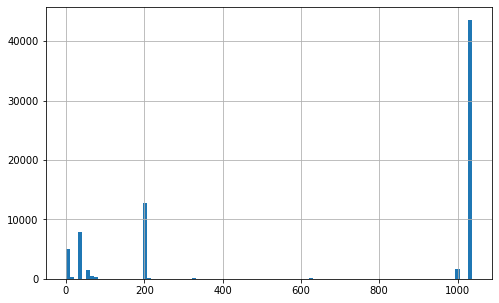

In [ ]:
pd.Series(df_edit['idinf']).hist(bins=100, figsize=(8,5))

Normalization with maximum absolute scaling (min-max scaling in fact):

In [ ]:
idinf = df_edit['idinf']
idinf = idinf / idinf.abs().max()
idinf.values

array([0.05019305, 0.03088803, 0.05019305, ..., 0.99903475, 0.99903475,
       0.99903475])

Normalization apply:

In [14]:
df_edit['idinf'] = df_edit['idinf'] / df_edit['idinf'].abs().max()

## **Latitude & longitude (*, decimal)**

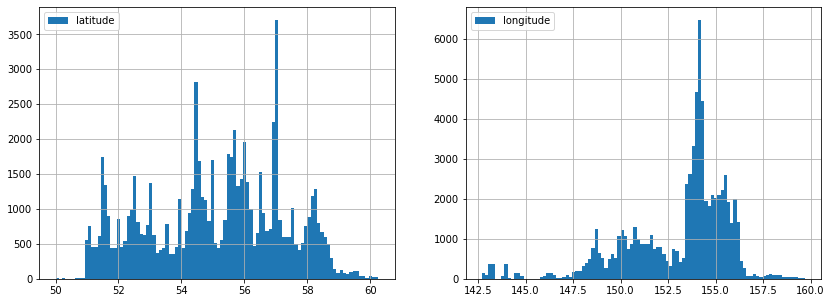

In [ ]:
plot, axis = plt.subplots(1, 2, figsize=(14,5))

axis[0].hist(df_edit['latitude'],bins=100);
axis[0].grid(visible=True)

axis[1].hist(df_edit['longitude'],bins=100);
axis[1].grid(visible=True)

axis[0].legend(['latitude'], loc='upper left')
axis[1].legend(['longitude'], loc='upper left')

Min-max normalization try:

In [ ]:
latitude2 = (df_edit['latitude'] - df_edit['latitude'].min()) / (df_edit['latitude'].max() - df_edit['latitude'].min())
longitude2 = (df_edit['longitude'] - df_edit['longitude'].min()) / (df_edit['longitude'].max() - df_edit['longitude'].min())

latitude2.min(), latitude2.max()

(0.0, 1.0)

Normalization apply:

In [ ]:
# df_edit['latitude'] = df_edit['latitude'] / df_edit['latitude'].abs().max()
# df_edit['longitude'] = df_edit['longitude'] / df_edit['longitude'].abs().max()

df_edit['latitude'] = (df_edit['latitude'] - df_edit['latitude'].min()) / (df_edit['latitude'].max() - df_edit['latitude'].min())
df_edit['longitude'] = (df_edit['longitude'] - df_edit['longitude'].min()) / (df_edit['longitude'].max() - df_edit['longitude'].min())

## **Region (fishing subzone, categorical):**

In [ ]:
df_edit.region.unique()

array([274, 273, 272, 275])

In [ ]:
df_edit = pd.get_dummies(df_edit, columns=['region'], dtype=float)

## **Course (*, degs):**

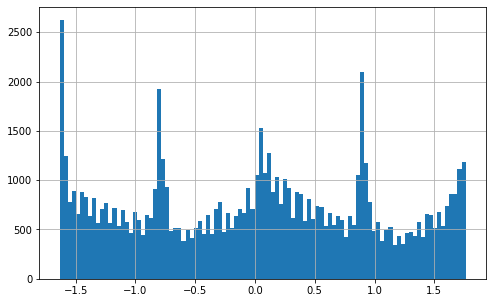

In [16]:
pd.Series(df_edit['course']).hist(bins=100, figsize=(8,5))

In [ ]:
(course - course.mean()) / course.std()

In [15]:
df_edit['course'] =  (df_edit['course'] - df_edit['course'].mean()) / df_edit['course'].std()

In [ ]:
df_edit['course'] =  df_edit['course'] /  df_edit['course'].abs().max()

## **Velocity:**

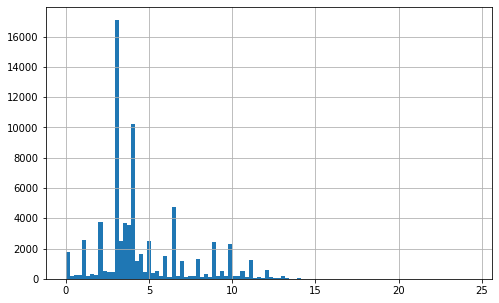

In [ ]:
pd.Series(df_edit['velocity']).hist(bins=100, figsize=(8,5))

Absolute maximum scaling:

In [ ]:
velocity = df_edit['velocity']
velocity = velocity / velocity.abs().max() # == (velocity - velocity.min()) / (velocity.max() - velocity.min())
velocity.min(), velocity.max()

(0.0, 1.0)

Normalization apply:

In [17]:
df_edit['velocity'] =  (df_edit['velocity'] - df_edit['velocity'].mean()) / df_edit['velocity'].std()

In [ ]:
df_edit['velocity'] = df_edit['velocity'] / df_edit['velocity'].abs().max()

## **Total ton ():**

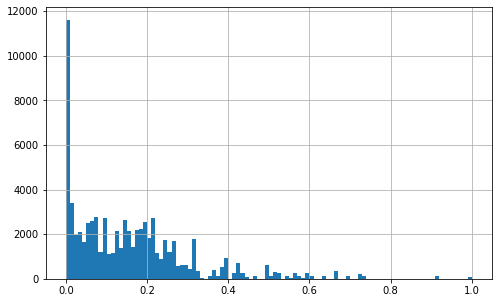

In [ ]:
df_edit['total_ton'].hist(bins=100, figsize=(8,5))

Maximum absolute scaling:

In [18]:
total_ton = df_edit['total_ton']
total_ton = total_ton / total_ton.abs().max()
total_ton.min(), total_ton.max()

(0.0, 1.0)

Scaling apply:

In [19]:
df_edit['total_ton'] = (df_edit['total_ton'] - df_edit['total_ton'].min()) / (df_edit['total_ton'].max() - df_edit['total_ton'].min())

## **Idves (ship code) & trawl (fishing gear):**

Standartization:

In [20]:
df_binary_idves = BinaryEncoder().fit_transform(df_edit['idves'], dtype=float)
df_binary_idves.columns = ([f'i{i}' for i in range(len(df_binary_idves.columns))])

df_binary_trawl = BinaryEncoder().fit_transform(df_edit['trawl'], dtype=float)
df_binary_trawl.columns = ([f't{i}' for i in range(len(df_binary_trawl.columns))])

In [21]:
df_binary_idves[df_edit.columns] = df_edit
df_binary_idves[df_binary_trawl.columns] = df_binary_trawl
df_edit = df_binary_idves
df_edit = df_edit.drop(columns=['idves', 'trawl'])



> # **X & Y samples**



In [22]:
pollok_df = df_edit
pollok_df = pollok_df.drop(['date', 'datetimes'], axis=1)

In [24]:
train_df = pollok_df.sample(frac=0.90, random_state=seed)
test_df = pollok_df[~pollok_df.index.isin(train_df.index)]

train_main = train_df.sample(frac=0.90, random_state=seed)
train_valid = train_df[~train_df.index.isin(train_main.index)]



> # **Models construct**



## Torch

In [ ]:
class Catch_predictor(torch.nn.Module):
    def __init__(self, dim, layers):                       
        
        super(Catch_predictor, self).__init__()                 # torch.nn.ReLU()    torch.nn.Tanh()  

        self.fc1 = torch.nn.Linear(dim, layers[0])          
        self.act1 = torch.nn.Tanh() 
        self.fc2 = torch.nn.Linear(layers[0], layers[1])     
        self.act2 = torch.nn.Tanh() 
        self.fc3 = torch.nn.Linear(layers[1], layers[2])     
        self.act3 = torch.nn.Tanh() 
        self.fc4 = torch.nn.Linear(layers[2], layers[3])     
        self.act4 = torch.nn.Tanh()                         
        self.fc5 = torch.nn.Linear(layers[3], layers[4])     
        self.act5 = torch.nn.Tanh() 
        self.fc6 = torch.nn.Linear(layers[4], layers[5])     
        self.act6 = torch.nn.Tanh() 
        self.fc7 = torch.nn.Linear(layers[5], 1)     
        
        # self.act7 = torch.nn.Sigmoid() 
        # self.fc8 = torch.nn.Linear(layers[6], layers[7])     
        # self.act8 = torch.nn.ReLU()                         
        # self.fc9 = torch.nn.Linear(layers[7], layers[8])     
        # self.act9 = torch.nn.ReLU() 
        # self.fc10 = torch.nn.Linear(layers[8], layers[9])     
        # self.act10 = torch.nn.ReLU() 
        # self.fc11 = torch.nn.Linear(layers[9], 1)     


    def forward(self, x):
        
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)
        x = self.fc6(x)
        x = self.act6(x)
        x = self.fc7(x)

        # x = self.act7(x)
        # x = self.fc8(x)
        # x = self.act8(x)
        # x = self.fc9(x)
        # x = self.act9(x)
        # x = self.fc10(x)
        # x = self.act10(x)
        # x = self.fc11(x)

        
        return x

In [ ]:
def MSE(pred, true):  
    sq = (true-pred)**2    
    return sq.mean()

def RMSE(pred, true):  
    dev = (true-pred)**2    
    return torch.sqrt(dev.mean())

Tensor-like XY samples:

In [ ]:
x_train = torch.tensor((train_main.drop(['ton'], axis=1).values), dtype=torch.float32)
y_train = torch.tensor(train_main['ton'].values, dtype=torch.float32)

x_valid = torch.tensor((train_valid.drop(['ton'], axis=1).values), dtype=torch.float32)
y_valid = torch.tensor(train_valid['ton'].values, dtype=torch.float32)

x_test = torch.tensor((test_df.drop(['ton'], axis=1).values), dtype=torch.float32)
y_test = torch.tensor(test_df['ton'].values, dtype=torch.float32)

print(x_train.shape, y_train.shape) 
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

torch.Size([59887, 27]) torch.Size([59887])
torch.Size([6654, 27]) torch.Size([6654])
torch.Size([7393, 27]) torch.Size([7393])


Model:

In [ ]:
layers = np.array([7, 11, 11, 11, 9, 5])# np.array([7, 11, 11, 11, 11, 11, 11, 9, 9, 5])
Gigachad = Catch_predictor(dim=x_train.shape[1], layers=layers)

optimizer = torch.optim.SGD(Gigachad.parameters(), lr=0.003)

epoch = 10000
batch_size = 512

valid_RMSE_history = []
valid_R2_history = []
valid_loss_history = []

for e in range(epoch):
    
    order = np.random.permutation(x_train.shape[0])
    Gigachad.train()

    for start_index in range(0, x_train.shape[0], batch_size):

        optimizer.zero_grad()
        

        batch_indexes = order[start_index : start_index+batch_size]

        X_batch = x_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds_t = Gigachad.forward(X_batch)

        loss_value = MSE(preds_t, y_batch)
        #print(loss_value, r2_score(y_batch.detach().numpy(), preds_t.detach().numpy()))
        loss_value.backward()

        optimizer.step()
        
            
    Gigachad.eval()

    valid_preds = Gigachad.forward(x_valid)

    valid_loss_history.append(MSE(valid_preds, y_valid).data.cpu())
    valid_R2_history.append(r2_score(y_valid.detach().numpy(), valid_preds.detach().numpy()).data)
    valid_RMSE_history.append(RMSE(valid_preds, y_valid).data.cpu())

    if e%100 == 0:
        print(MSE(valid_preds, y_valid).data, 
            r2_score(y_valid.detach().numpy(), valid_preds.detach().numpy()).round(5),
            RMSE(valid_preds, y_valid).data)

tensor(21.9650) -0.01283 tensor(4.6867)
tensor(21.7232) -0.00168 tensor(4.6608)
tensor(21.7169) -0.00139 tensor(4.6601)
tensor(21.7153) -0.00131 tensor(4.6600)
tensor(21.7145) -0.00128 tensor(4.6599)
tensor(21.7141) -0.00126 tensor(4.6598)
tensor(21.7139) -0.00125 tensor(4.6598)
tensor(21.7138) -0.00125 tensor(4.6598)


KeyboardInterrupt: ignored

In [ ]:
test_pred = Gigachad.forward(x_test)

print(sklearn.metrics.r2_score(y_test.detach().numpy(), test_pred.detach().numpy()))
print(RMSE(test_pred, y_test).data)

-0.0007816914242793072
tensor(4.3123)


In [ ]:
plt.plot(y_test, test_pred, 'o', c = 'b', label = 'Torch pred distr')

plt.ylabel('preds');  
plt.xlabel('y_test');
    
plt.legend(loc = 'upper right');

## Keras

In [25]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import LambdaCallback
from keras import layers
from keras import activations
from keras import optimizers

Array-like samples form:

In [26]:
x_train = np.array((train_main.drop(['ton'], axis=1).values))
y_train = np.array(train_main['ton'].values)

x_test = np.array((test_df.drop(['ton'], axis=1).values))
y_test = np.array(test_df['ton'].values)

print(x_train.shape, y_train.shape) 
print(x_test.shape, y_test.shape)

(59887, 24) (59887,)
(7393, 24) (7393,)


Model:

In [106]:
%%time

model = keras.Sequential([keras.Input(shape=x_test.shape[1]), 
                          layers.Dense(7, activation=activations.relu), 
                          layers.Dense(15, activation=activations.relu),
                          layers.Dense(15, activation=activations.relu), 
                          layers.Dense(15, activation=activations.relu),
                          layers.Dense(7, activation=activations.relu), 
                          layers.Dense(5, activation=activations.relu), 
                          layers.Dense(1)])

model.compile(loss='mse', optimizer='adamax', metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.fit(x_train, y_train, epochs=100, validation_split=0.05, batch_size=512, verbose=1)

Epoch 1/100
112/112 [==============================] - 1s 4ms/step - loss: 18.3903 - root_mean_squared_error: 4.2884 - val_loss: 22.9253 - val_root_mean_squared_error: 4.7880
Epoch 2/100
112/112 [==============================] - 0s 3ms/step - loss: 17.4511 - root_mean_squared_error: 4.1775 - val_loss: 22.9551 - val_root_mean_squared_error: 4.7911
Epoch 3/100
112/112 [==============================] - 0s 3ms/step - loss: 17.4560 - root_mean_squared_error: 4.1780 - val_loss: 22.9288 - val_root_mean_squared_error: 4.7884
Epoch 4/100
112/112 [==============================] - 0s 4ms/step - loss: 17.4557 - root_mean_squared_error: 4.1780 - val_loss: 22.9242 - val_root_mean_squared_error: 4.7879
Epoch 5/100
112/112 [==============================] - 1s 4ms/step - loss: 17.4560 - root_mean_squared_error: 4.1780 - val_loss: 22.9382 - val_root_mean_squared_error: 4.7894
Epoch 6/100
112/112 [==============================] - 1s 5ms/step - loss: 17.4503 - root_mean_squared_error: 4.1774 - val_lo

In [107]:
preds_ker = model.predict(x_test)

scores = model.evaluate(x_test, y_test, batch_size=512)
R2_keras = r2_score(y_test, preds_ker)
print(scores)
print('R2: ', R2_keras)

15/15 [==============================] - 0s 2ms/step - loss: 18.0412 - root_mean_squared_error: 4.2475
[18.041196823120117, 4.247492790222168]
R2:  0.029074265158330337


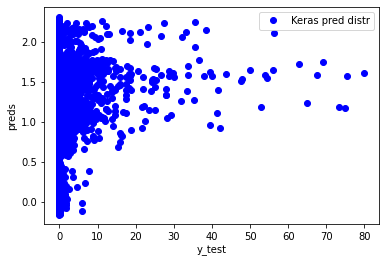

In [108]:
plt.plot(y_test, preds_ker, 'o', c = 'b', label = 'Keras pred distr')

plt.ylabel('preds');  
plt.xlabel('y_test');
    
plt.legend(loc = 'upper right');

## RF

In [63]:
def RMSE_ar(pred, true):  
    dev = (pred-true)**2    
    return np.sqrt(dev.mean())

In [32]:
RF_Reg = RandomForestRegressor(n_estimators = 500, criterion='squared_error', random_state=seed, min_samples_split=5) # random_state=seed
RF_Reg.fit(x_train, y_train)

preds_rf = RF_Reg.predict(x_test)

In [39]:
# RF_Reg = RandomForestRegressor(n_estimators = 500, criterion='squared_error', random_state=42, min_samples_split=5)
RMSE_r = RMSE_ar(y_test, preds_rf)
R2_RF = sklearn.metrics.r2_score(y_test, preds_rf)
print(R2_RF, RMSE_r) 

0.12449366463784195 4.033381542660547


In [ ]:
# n_estimators = 500
RMSE_r = RMSE_rf(y_test, preds_rf)
R2_RF = sklearn.metrics.r2_score(y_test, preds_rf)
print(R2_RF, RMSE_r) 

0.11743364202099404 4.04961134444323


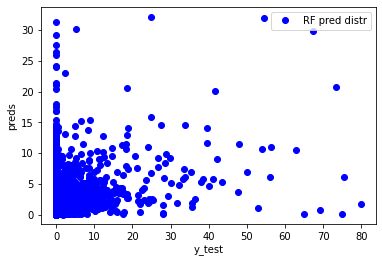

In [45]:
plt.plot(y_test, preds_rf, 'o', c = 'b', label = 'RF pred distr')
    
plt.ylabel('preds');  
plt.xlabel('y_test');
    
plt.legend(loc = 'upper right');

In [102]:
preds_rf

array([1.83886567, 0.45519557, 0.68650735, ..., 0.00978934, 0.05477275,
       0.07888763])

## Elastic Net 

In [87]:
from sklearn.linear_model import ElasticNetCV

ENet = ElasticNetCV(l1_ratio=0.35, eps=0.0005, n_alphas=150, max_iter=100000, cv=None, copy_X=True, verbose=0, random_state=seed)
ENet.fit(x_train, y_train)

ElasticNetCV(eps=0.0005, l1_ratio=0.25, max_iter=100000, n_alphas=150)

In [88]:
preds_ENet = ENet.predict(x_test)

In [86]:
RMSE_ENet = RMSE_ar(y_test, preds_ENet)
R2_ENet = sklearn.metrics.r2_score(y_test, preds_ENet)
print(R2_ENet, RMSE_ENet) 

0.05353941057859413 4.1936378884751635


In [89]:
RMSE_ENet = RMSE_ar(y_test, preds_ENet)
R2_ENet = sklearn.metrics.r2_score(y_test, preds_ENet)
print(R2_ENet, RMSE_ENet) 

0.053407741405013254 4.193929582412746


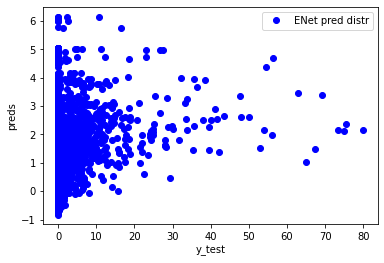

In [90]:
plt.plot(y_test, preds_ENet, 'o', c = 'b', label = 'ENet pred distr')
    
plt.ylabel('preds');  
plt.xlabel('y_test');
    
plt.legend(loc = 'upper right');

In [96]:
y_t = pd.Series(y_test)

In [100]:
y_t.unique()

array([0.        , 1.28      , 0.13913043, ..., 0.07626298, 0.19119339,
       0.0699488 ])

In [101]:
preds_ENet

array([ 2.13082277,  1.77473553,  1.39740411, ..., -0.63520653,
       -0.62641072, -0.73455378])